## Introduction:

- This notebook is my 1st implementation for maximizing Customer Lifetime Value (CLV) using Deep Q Networks (Q learning + LSTM).. 

- The problem is seen as a deep reinforcement learning task .. where each customer has a current state (his complete record in the database), take an action (continue as active customer, close his account, ...) and go to next state and receive a reward (represented by his total balance i.e. FINANCED_AMOUNTS)


- The sample data is gathered from Credit Agricole Egypt (as of date: March, April 2017) .. March's data represent current state of the customer, April data represent next state for the same customer .. 

- We assume that we are dealing with a partially observable MDP, such that the next states are not compeletely known and hence, LSTM is utilized to learn them .. then, DQN is utilized to learn the Q_function (next rewards) .. 
 
### - This notebook is organized as follows:
__1. Reading the customer data of March (the customer record represents his current state)__  

    1.1. Data Exploration 
    
    1.2. Missing values imputation for March's data .. 
    
    1.3. Data transformation .. 
    
__2. Loading the customer data of June  (the customer record represents his next state)__

    2.1. Data Exploration 
    
    2.2. Missing values imputation for March's data .. 
    
    2.3. Data transformation
   
__3. LSTM ..__

    3.1. Model training ==> 80-20 cross validation is performed on March's data .. 80% of the current state for training .. 20% for testing .. 
    
    3.2. Q Learning model ..  
    
    
Main steps:¶

- RL-LSTM, is expected to handle partial observability by explicitly modeling long-term dependencies of future rewards on history (modeling the sequances)

- Deep RL baseline is DQN, where we treat it as state st, and optimize network parameters to obtain an approximate Q-function once a good Q-network is learned, it can be used to select actions in a greedy fashion (Selects actions that has maximum reward) .. 

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets, linear_model
from tensorflow.python.ops import rnn, rnn_cell
from sklearn import preprocessing
from sknn.mlp import Regressor, Layer
import pandas as pd

## plotting .. 
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import csv
import sys

import datetime as dt


## warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading the data:

In [2]:
df = pd.read_excel('cltb.xlsx', header=0, delimiter=',')[0:200]

In [3]:
df.head()

,ACCOUNT_NUMBER,BRANCH_CODE,APPLICATION_NUM,CUSTOMER_ID,PRODUCT_CODE,PRODUCT_CATEGORY,BOOK_DATE,VALUE_DATE,MATURITY_DATE,AMOUNT_FINANCED,...,TAKEN_OVER,ASSET_TYPE,MUR_CONT_STATUS,RATE_CHG_ACTION,OFFICER_CD,LOB_ID,AS_OF_DATE,EXTRACTION_DATE,REC_STATUS,BUCKET_NUMBER
0,008FIDU152580003,13,NaN,47007501,TPFI,CORPORATE,2015-12-17,2015-12-14,2016-06-11,185462.50,...,NaN,NaN,NaN,E,NaN,100,2017-03-30,2017-03-31 09:33:27,S,0
1,0130701153020001,13,H0013701101033,100345296,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-12-03,3446.78,...,NaN,NaN,NaN,E,NaN,302,2017-03-30,2017-03-31 09:30:56,S,0
2,0130701153020002,13,H0013701101032,100342252,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-12-03,2899.35,...,NaN,NaN,NaN,E,NaN,302,2017-03-30,2017-03-31 09:30:56,S,0
3,0130701153020003,13,H0013701101031,100340936,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-11-03,912.53,...,NaN,NaN,NaN,E,NaN,302,2017-03-30,2017-03-31 09:30:57,S,0
4,0130701153020004,13,H0013701111018,100389617,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-09-03,2016-10-03,23345.17,...,NaN,NaN,NaN,E,NaN,302,2017-03-30,2017-03-31 09:30:57,S,0


## Data Exploration .. 

In [4]:
np.shape(df)

(200, 281)

In [5]:
df.isnull().any()

ACCOUNT_NUMBER             False
BRANCH_CODE                False
APPLICATION_NUM             True
CUSTOMER_ID                False
PRODUCT_CODE               False
PRODUCT_CATEGORY           False
BOOK_DATE                  False
VALUE_DATE                 False
MATURITY_DATE              False
AMOUNT_FINANCED            False
DOWNPAYMENT_AMOUNT          True
CURRENCY                   False
ORIGINAL_ST_DATE           False
PRIMARY_APPLICANT_ID       False
PRIMARY_APPLICANT_NAME     False
USER_DEFINED_STATUS        False
CALC_REQD                  False
BACK_VAL_EFF_DT             True
AUTO_MAN_ROLLOVER          False
SCHEDULE_BASIS             False
UDE_ROLLOVER_BASIS         False
ROLLOVER_TYPE              False
SPECIAL_AMOUNT              True
RATE_CODE_PREF             False
PASSBOOK_FACILITY          False
ATM_FACILITY               False
ALLOW_BACK_PERIOD_ENTRY    False
INT_STMT                   False
TRACK_RECEIVABLE_ALIQ      False
TRACK_RECEIVABLE_MLIQ      False
          

In [6]:
df.isnull().sum()

ACCOUNT_NUMBER               0
BRANCH_CODE                  0
APPLICATION_NUM             30
CUSTOMER_ID                  0
PRODUCT_CODE                 0
PRODUCT_CATEGORY             0
BOOK_DATE                    0
VALUE_DATE                   0
MATURITY_DATE                0
AMOUNT_FINANCED              0
DOWNPAYMENT_AMOUNT         200
CURRENCY                     0
ORIGINAL_ST_DATE             0
PRIMARY_APPLICANT_ID         0
PRIMARY_APPLICANT_NAME       0
USER_DEFINED_STATUS          0
CALC_REQD                    0
BACK_VAL_EFF_DT            200
AUTO_MAN_ROLLOVER            0
SCHEDULE_BASIS               0
UDE_ROLLOVER_BASIS           0
ROLLOVER_TYPE                0
SPECIAL_AMOUNT             200
RATE_CODE_PREF               0
PASSBOOK_FACILITY            0
ATM_FACILITY                 0
ALLOW_BACK_PERIOD_ENTRY      0
INT_STMT                     0
TRACK_RECEIVABLE_ALIQ        0
TRACK_RECEIVABLE_MLIQ        0
                          ... 
ALLOW_MULTI_PARTY          200
POST_CON

## Comment: 

We have 6051 row data related to 6051 customer .. hence, it makes sense to remove those columns with 6051 missing value (the whole column is nan) !  

In [7]:
df = df.dropna(axis=1,how='all')

In [8]:
df.head()

,ACCOUNT_NUMBER,BRANCH_CODE,APPLICATION_NUM,CUSTOMER_ID,PRODUCT_CODE,PRODUCT_CATEGORY,BOOK_DATE,VALUE_DATE,MATURITY_DATE,AMOUNT_FINANCED,...,HANDOVER_CONF,LOAN_STLMNT_NOTICEFLG,AUTO_CLOSE_COLLATERAL,STATUS_CHANGE_MODE,RATE_CHG_ACTION,LOB_ID,AS_OF_DATE,EXTRACTION_DATE,REC_STATUS,BUCKET_NUMBER
0,008FIDU152580003,13,NaN,47007501,TPFI,CORPORATE,2015-12-17,2015-12-14,2016-06-11,185462.50,...,NaN,N,N,A,E,100,2017-03-30,2017-03-31 09:33:27,S,0
1,0130701153020001,13,H0013701101033,100345296,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-12-03,3446.78,...,NaN,N,N,A,E,302,2017-03-30,2017-03-31 09:30:56,S,0
2,0130701153020002,13,H0013701101032,100342252,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-12-03,2899.35,...,NaN,N,N,A,E,302,2017-03-30,2017-03-31 09:30:56,S,0
3,0130701153020003,13,H0013701101031,100340936,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-11-03,912.53,...,NaN,N,N,A,E,302,2017-03-30,2017-03-31 09:30:57,S,0
4,0130701153020004,13,H0013701111018,100389617,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-09-03,2016-10-03,23345.17,...,N,N,N,A,E,302,2017-03-30,2017-03-31 09:30:57,S,0


ALL Null values columns are dropped :)

## Comment: 

It seems that FIELD_CHAR_13 contains the name of the customers .. I gonna remove it for confidentiality purposes .. (excluded from the state of the customer) ..

Also, let's replace ALL datatime variables (i.e. timestamp) with only the year part .. as we are not interested in the time part in our analysis .. and more importently .. to avoid getting error while converting these variables to tensors .. 

In [9]:
cols_date = ['ORIGINAL_ST_DATE', 'FIELD_DATE_1', 'FIELD_DATE_2', 'FIELD_DATE_3', 'FIELD_DATE_7', 'FIELD_DATE_8', 'FIELD_DATE_9'
             ,'FIELD_DATE_10', 'MIGRATION_DATE', 'AS_OF_DATE', 'EXTRACTION_DATE', 'CHECKER_DT_STAMP', 'MAKER_DT_STAMP', 'ORIGINAL_ST_DATE',
             'BOOK_DATE', 'VALUE_DATE', 'MATURITY_DATE']


for i in xrange(len(cols_date)):
    df[cols_date[i]] = df[cols_date[i]].apply(lambda x: x)

df[cols_date[1]].head()

0          NaT
1   2010-12-09
2   2010-11-24
3   2010-11-21
4   2011-10-10
Name: FIELD_DATE_1, dtype: datetime64[ns]

### Data types of the variables .. 

In [10]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('<M8[ns]'): [u'BOOK_DATE',
  u'VALUE_DATE',
  u'MATURITY_DATE',
  u'ORIGINAL_ST_DATE',
  u'MAKER_DT_STAMP',
  u'CHECKER_DT_STAMP',
  u'FIELD_DATE_1',
  u'FIELD_DATE_2',
  u'FIELD_DATE_3',
  u'FIELD_DATE_7',
  u'FIELD_DATE_8',
  u'FIELD_DATE_9',
  u'FIELD_DATE_10',
  u'MIGRATION_DATE',
  u'AS_OF_DATE',
  u'EXTRACTION_DATE'],
 dtype('int64'): [u'BRANCH_CODE',
  u'CUSTOMER_ID',
  u'PRIMARY_APPLICANT_ID',
  u'VERSION_NO',
  u'LATEST_ESN',
  u'PROCESS_NO',
  u'FUNDED_STATUS',
  u'DR_PROD_AC',
  u'CR_PROD_AC',
  u'DR_ACC_BRN',
  u'CR_ACC_BRN',
  u'LOB_ID',
  u'BUCKET_NUMBER'],
 dtype('float64'): [u'AMOUNT_FINANCED',
  u'RETRIES_AUTO_LIQ',
  u'AMOUNT_DISBURSED',
  u'NO_OF_INSTALLMENTS',
  u'FREQUENCY',
  u'FIELD_CHAR_3',
  u'FIELD_CHAR_4',
  u'FIELD_CHAR_8',
  u'FIELD_CHAR_11',
  u'FIELD_NUMBER_1',
  u'FIELD_NUMBER_2',
  u'FIELD_NUMBER_3',
  u'FIELD_NUMBER_4',
  u'FIELD_NUMBER_5',
  u'NET_PRINCIPAL',
  u'EMI_AMOUNT',
  u'DUE_DATES_ON',
  u'AMOUNT_UTILIZED'],
 dtype('O'): [u'ACCOUNT_NUM

The majority of the data are categorical .. few of them are intergers and floats or even others (i.e. dates..) ..

We are more intrested in float variables as the int ones mainly represent codes .. 

In [11]:
df.describe()

,BRANCH_CODE,CUSTOMER_ID,AMOUNT_FINANCED,PRIMARY_APPLICANT_ID,RETRIES_AUTO_LIQ,VERSION_NO,LATEST_ESN,PROCESS_NO,AMOUNT_DISBURSED,FUNDED_STATUS,...,NET_PRINCIPAL,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,EMI_AMOUNT,DUE_DATES_ON,AMOUNT_UTILIZED,LOB_ID,BUCKET_NUMBER
count,200,2.000000e+02,200.000000,2.000000e+02,170,200.000000,200.000000,200,200.000000,200,...,200.00000,2.000000e+02,2.000000e+02,200.000000,200.000000,170.000000,29.000000,200,200.000000,200
mean,13,9.822991e+07,57386.462750,9.822991e+07,999,15.605000,449.875000,1,57386.462750,1000,...,80378.31250,1.662368e+12,6.251886e+11,60.990000,49.485000,1890.751118,4.482759,0,311.300000,0
std,0,1.344408e+07,64042.486851,1.344408e+07,0,11.429002,224.934249,0,64042.486851,0,...,58850.70883,3.318009e+12,1.980267e+12,87.493517,81.446161,1245.778147,5.584549,0,71.583244,0
min,13,2.609001e+06,679.220000,2.609001e+06,999,1.000000,6.000000,1,679.220000,1000,...,22000.00000,2.143007e+10,2.006031e+08,2.000000,1.000000,0.000000,3.000000,0,100.000000,0
25%,13,1.003873e+08,20265.045000,1.003873e+08,999,4.750000,297.500000,1,20265.045000,1000,...,50000.00000,1.328300e+11,1.314300e+11,13.000000,13.000000,1264.350000,3.000000,0,302.000000,0
50%,13,1.004559e+08,40143.310000,1.004559e+08,999,14.000000,439.000000,1,40143.310000,1000,...,63750.00000,3.028300e+11,1.428300e+11,19.500000,14.000000,1640.445000,3.000000,0,302.000000,0
75%,13,1.005939e+08,66356.920000,1.005939e+08,999,27.000000,587.750000,1,66356.920000,1000,...,87850.00000,1.102830e+12,3.828300e+11,41.250000,38.000000,2162.510000,3.000000,0,302.000000,0
max,13,1.007387e+08,440000.000000,1.007387e+08,999,37.000000,893.000000,1,440000.000000,1000,...,440000.00000,1.111818e+13,2.601978e+13,312.000000,312.000000,8687.300000,27.000000,0,801.000000,0


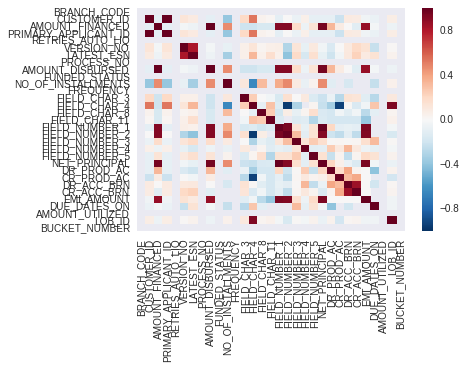

In [12]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [13]:
df.corr()

,BRANCH_CODE,CUSTOMER_ID,AMOUNT_FINANCED,PRIMARY_APPLICANT_ID,RETRIES_AUTO_LIQ,VERSION_NO,LATEST_ESN,PROCESS_NO,AMOUNT_DISBURSED,FUNDED_STATUS,...,NET_PRINCIPAL,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,EMI_AMOUNT,DUE_DATES_ON,AMOUNT_UTILIZED,LOB_ID,BUCKET_NUMBER
BRANCH_CODE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUSTOMER_ID,NaN,1.000000,-0.099006,1.000000,NaN,0.125504,0.088371,NaN,-0.099006,NaN,...,-0.091288,-0.093450,-0.217954,0.091980,0.078401,-0.044121,-0.068108,NaN,0.075278,NaN
AMOUNT_FINANCED,NaN,-0.099006,1.000000,-0.099006,NaN,-0.028922,-0.050626,NaN,1.000000,NaN,...,0.956942,0.330386,0.082383,0.003844,-0.116199,0.873586,-0.030654,NaN,-0.061574,NaN
PRIMARY_APPLICANT_ID,NaN,1.000000,-0.099006,1.000000,NaN,0.125504,0.088371,NaN,-0.099006,NaN,...,-0.091288,-0.093450,-0.217954,0.091980,0.078401,-0.044121,-0.068108,NaN,0.075278,NaN
RETRIES_AUTO_LIQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VERSION_NO,NaN,0.125504,-0.028922,0.125504,NaN,1.000000,0.817313,NaN,-0.028922,NaN,...,-0.031547,-0.148541,0.005784,0.094015,0.202875,0.141951,-0.229346,NaN,0.007946,NaN
LATEST_ESN,NaN,0.088371,-0.050626,0.088371,NaN,0.817313,1.000000,NaN,-0.050626,NaN,...,-0.080363,-0.203770,-0.035228,0.101751,0.227905,0.089972,0.144352,NaN,0.040304,NaN
PROCESS_NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMOUNT_DISBURSED,NaN,-0.099006,1.000000,-0.099006,NaN,-0.028922,-0.050626,NaN,1.000000,NaN,...,0.956942,0.330386,0.082383,0.003844,-0.116199,0.873586,-0.030654,NaN,-0.061574,NaN
FUNDED_STATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The above built in functions show that there is strong corelation between some variables (i.e. AMOUNT_FINANCED and AMOUNT_DISBURSED) .. it also shows that there variables with NaN correlation (i.e. BRANCH_CODE) that is non sense to calc. their linear relationship with the other variables .. finally, there is a weak correlation between set of variables .. i.e. CUSTOMER_ID and FIELD_NUMBER_5

## Plotting .. 

### AMOUNT_FINANCED .. 

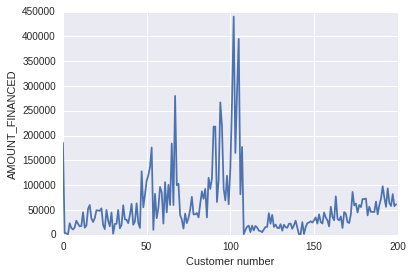

In [14]:
plt.plot(df['AMOUNT_FINANCED'])
plt.xlabel("Customer number")
plt.ylabel("AMOUNT_FINANCED")

The above figure is misleading .. as it doesn't tell about the skewness of the plot .. 

let's replace it with histogram ..

(array([ 110.,   57.,   17.,    4.,    6.,    0.,    4.,    0.,    1.,    1.]),
 array([    679.22 ,   44611.298,   88543.376,  132475.454,  176407.532,
         220339.61 ,  264271.688,  308203.766,  352135.844,  396067.922,
         440000.   ]),
 <a list of 10 Patch objects>)

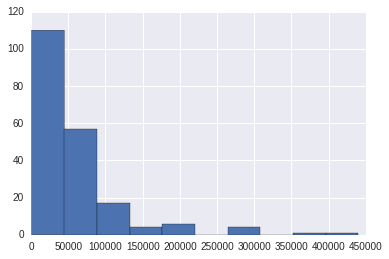

In [15]:
plt.hist(df['AMOUNT_FINANCED'])

The histogram above is meaningful .. it shows that the data is +ve skewed .. the majority of the customers have amounts in the 1st bin .. small portion have amounts higher than 1 billion .. 

This matches the values of mean and median calculated earlier .. (mean value is higher than the median) .. 

### AMOUNT_DISBURSED:

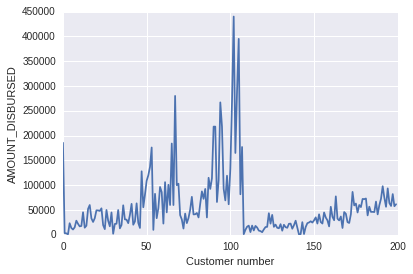

In [16]:
plt.plot(df['AMOUNT_DISBURSED'])
plt.xlabel("Customer number")
plt.ylabel("AMOUNT_DISBURSED")

(array([ 110.,   57.,   17.,    4.,    6.,    0.,    4.,    0.,    1.,    1.]),
 array([    679.22 ,   44611.298,   88543.376,  132475.454,  176407.532,
         220339.61 ,  264271.688,  308203.766,  352135.844,  396067.922,
         440000.   ]),
 <a list of 10 Patch objects>)

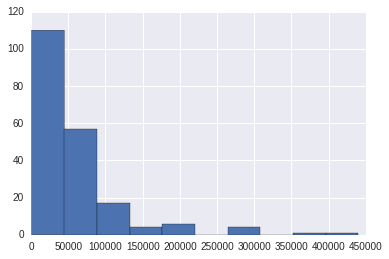

In [17]:
plt.hist(df['AMOUNT_DISBURSED'])

As expected .. the AMOUNT_FINANCED is stongly correlated with the AMOUNT_DISBURSED .. and this is confirmed through the matching plots .. 

### Let's plot ALL the numerical variables in one shot !

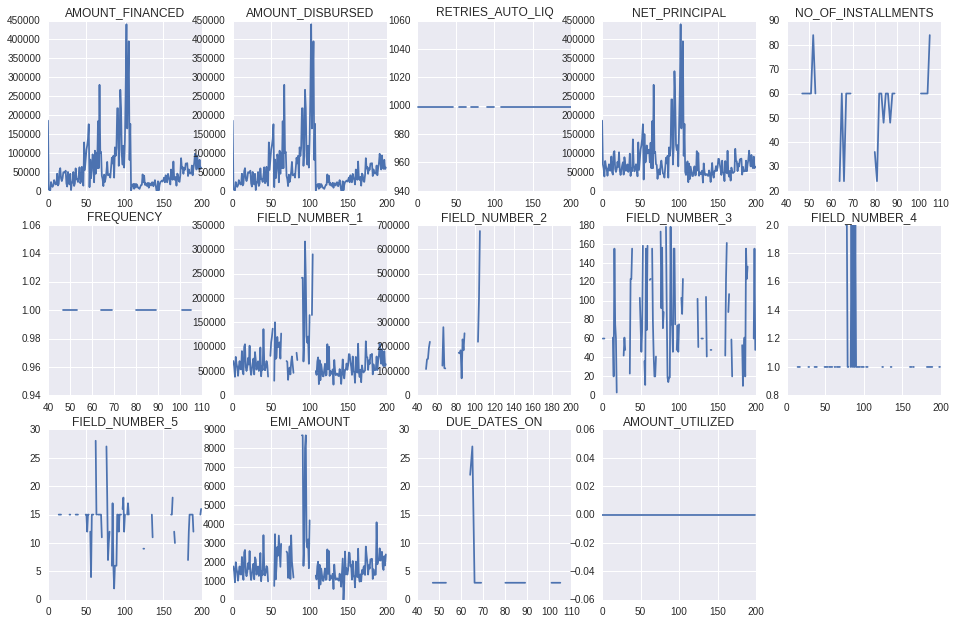

In [18]:
fig = plt.figure(figsize=(16, 80))
numeric_cols = ['AMOUNT_FINANCED', 'AMOUNT_DISBURSED', 'RETRIES_AUTO_LIQ', 'NET_PRINCIPAL', 'NO_OF_INSTALLMENTS', 
                'FREQUENCY', 'FIELD_NUMBER_1', 'FIELD_NUMBER_2', 'FIELD_NUMBER_3', 'FIELD_NUMBER_4', 'FIELD_NUMBER_5', 
                'EMI_AMOUNT', 'DUE_DATES_ON', 'AMOUNT_UTILIZED']

plot_count = 0
for numeric_col in numeric_cols:
    plot_count += 1
    plt.subplot(22, 5, plot_count)
    sns.plt.plot(numeric_col, data=df)
    plt.title(numeric_col)

In [19]:
df['STATUS_CHANGE_MODE'].unique()

array([u'A'], dtype=object)

## Comment:

Exploring April data is still not done as I don't have access to April data yet .. 

## Filling in the missing values .. 

As shown earlier .. the data contain lots of NAs .. we already removed the columns that are all NAs .. however, we can't remove the NAs rows from the rest of the columns as their count is huge (i.e. 3000+ out of 6000+) .. hence, let's replace NAs of numerical variables by the mean value and of the categorical variables by the mode .. 

In [20]:
## although these are int .. I gonna fill them by the mode just becuase these are mainly codes .. 
cols_int = ['BRANCH_CODE',  'CUSTOMER_ID',
  'PRIMARY_APPLICANT_ID',
  'VERSION_NO',
  'LATEST_ESN',
  'PROCESS_NO',
  'FUNDED_STATUS',
  'DR_PROD_AC',
  'CR_PROD_AC',
  'DR_ACC_BRN',
  'CR_ACC_BRN',
  'LOB_ID',
  'BUCKET_NUMBER']

# df[cols_int] = df[cols_int].fillna(df[cols_int].mode())
# df[cols_int].head()

df[cols_int] = df[cols_int].apply(lambda x:x.fillna(x.value_counts().index[0]))
df[cols_int].head()

,BRANCH_CODE,CUSTOMER_ID,PRIMARY_APPLICANT_ID,VERSION_NO,LATEST_ESN,PROCESS_NO,FUNDED_STATUS,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,LOB_ID,BUCKET_NUMBER
0,13,47007501,47007501,2,6,1,1000,10069780000116,26019780000043,13,13,100,0
1,13,100345296,100345296,1,31,1,1000,131100111993,131100111993,13,13,302,0
2,13,100342252,100342252,3,47,1,1000,131100111453,131100111453,13,13,302,0
3,13,100340936,100340936,1,14,1,1000,131100111123,131100111123,13,13,302,0
4,13,100389617,100389617,25,548,1,1000,132830004272,132830004272,13,13,302,0


In [21]:
## floats .. 

cols_float = ['AMOUNT_FINANCED',
  'RETRIES_AUTO_LIQ',
  'AMOUNT_DISBURSED',
  'FIELD_CHAR_3',
  'FIELD_CHAR_4',
  'FIELD_CHAR_8',
  'FIELD_CHAR_11',
  'FIELD_NUMBER_1',
  'FIELD_NUMBER_3',
  'FIELD_NUMBER_4',
  'FIELD_NUMBER_5',
  'NET_PRINCIPAL',
  'EMI_AMOUNT',
  'AMOUNT_UTILIZED']

df[cols_float] = df[cols_float].fillna(df[cols_float].median())
df[cols_float].head()

,AMOUNT_FINANCED,RETRIES_AUTO_LIQ,AMOUNT_DISBURSED,FIELD_CHAR_3,FIELD_CHAR_4,FIELD_CHAR_8,FIELD_CHAR_11,FIELD_NUMBER_1,FIELD_NUMBER_3,FIELD_NUMBER_4,FIELD_NUMBER_5,NET_PRINCIPAL,EMI_AMOUNT,AMOUNT_UTILIZED
0,185462.50,999,185462.50,2,38,21,60,62500,60,1,15,185462.5,1640.445,0
1,3446.78,999,3446.78,5,124,22,60,70400,60,1,15,70400.0,1761.370,0
2,2899.35,999,2899.35,5,124,8,60,58800,60,1,15,58800.0,1481.580,0
3,912.53,999,912.53,5,124,21,60,38000,60,1,15,38000.0,925.230,0
4,23345.17,999,23345.17,5,124,21,60,79000,60,1,15,79000.0,1986.320,0


In [22]:
cols_cat = ['ACCOUNT_NUMBER',
  'APPLICATION_NUM',
  'PRODUCT_CODE',
  'PRODUCT_CATEGORY',
  'CURRENCY',
  'PRIMARY_APPLICANT_NAME',
  'USER_DEFINED_STATUS',
  'CALC_REQD',
  'AUTO_MAN_ROLLOVER',
  'SCHEDULE_BASIS',
  'UDE_ROLLOVER_BASIS',
  'ROLLOVER_TYPE',
  'RATE_CODE_PREF',
  'PASSBOOK_FACILITY',
  'ATM_FACILITY',
  'ALLOW_BACK_PERIOD_ENTRY',
  'INT_STMT',
  'TRACK_RECEIVABLE_ALIQ',
  'TRACK_RECEIVABLE_MLIQ',
  'LIQUIDATION_MODE',
  'AMEND_PAST_PAID_SCHEDULE',
  'CHEQUE_BOOK_FACILITY',
  'LIQ_BACK_VALUED_SCHEDULES',
  'LIQ_COMP_DATES_FLAG',
  'ACCOUNT_STATUS',
  'AUTH_STAT',
  'STOP_ACCRUALS',
  'AMORTIZED',
 'RECALC_ACTION_CODE',
  'MAKER_ID',
  'CHECKER_ID',
  'ARVN_APPLIED',
  'ALT_ACC_NO',
  'PARTIAL_LIQUIDATION',
  'ALIQ_REVERSED_PMT',
  'FREQUENCY_UNIT',
  'FIRST_INS_DATE',
  'FIELD_CHAR_1',
  'FIELD_CHAR_2',
  'FIELD_CHAR_5',
  'FIELD_CHAR_6',
  'FIELD_CHAR_9',   
  'FIELD_CHAR_12',
  'FIELD_CHAR_10',
  'FIELD_CHAR_14',
  'FIELD_CHAR_15',
  'FIELD_CHAR_16',
  'FIELD_CHAR_17',
  'FIELD_CHAR_18',
  'FIELD_CHAR_19',
  'FIELD_CHAR_20',
  'FIELD_DATE_7',
  'ROLL_BY',
  'MATURITY_TYPE',
  'DR_PAYMENT_MODE',
  'CR_PAYMENT_MODE',
  'CUTOFF_TRANSACTION',
  'DELINQUENCY_STATUS',
  'USER_REF_NO',
  'ROLLOVER_ALLOWED',
  'COMMITMENT_TYPE',
  'LOAN_TYPE',
  'MODULE_CODE',
  'PACKING_CREDIT',
  'LEASE_PAYMENT_MODE',
 'ALLOW_BULK_PAYMNET',
 'STOP_DSBR',
 'INTERMEDIARY_INITIATED',
  'NOTARY_AUTO_CONFIRMED',
 'RECALC_ANNUITY',
  'LOAN_STMT_REQD',
  'SUBSYSTEMSTAT',
 'USE_GUARANTOR',
  'LOAN_AGAINST_SAL',
  'OPEN_LINE_LOAN',
  'REVOLVING_TYPE',
  'PROJECT_ACCOUNT',
  'HANDOVER_CONF',
  'LOAN_STLMNT_NOTICEFLG',
  'AUTO_CLOSE_COLLATERAL',
  'STATUS_CHANGE_MODE',
  'RATE_CHG_ACTION',
  'REC_STATUS']

# df[cols_cat].fillna(df[cols_cat].mode())  # ya3ni delw2ty el O NAs mish bettmeli 
df[cols_cat] = df[cols_cat].apply(lambda x:x.fillna(x.value_counts().index[0]))
df[cols_cat].head()

,ACCOUNT_NUMBER,APPLICATION_NUM,PRODUCT_CODE,PRODUCT_CATEGORY,CURRENCY,PRIMARY_APPLICANT_NAME,USER_DEFINED_STATUS,CALC_REQD,AUTO_MAN_ROLLOVER,SCHEDULE_BASIS,...,LOAN_AGAINST_SAL,OPEN_LINE_LOAN,REVOLVING_TYPE,PROJECT_ACCOUNT,HANDOVER_CONF,LOAN_STLMNT_NOTICEFLG,AUTO_CLOSE_COLLATERAL,STATUS_CHANGE_MODE,RATE_CHG_ACTION,REC_STATUS
0,008FIDU152580003,H0013709131032,TPFI,CORPORATE,EUR,ORKILA EGYPT CHEMICALS,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
1,0130701153020001,H0013701101033,0701,RETAIL_AUTO_LOANS,EGP,BASEM220979,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
2,0130701153020002,H0013701101032,0701,RETAIL_AUTO_LOANS,EGP,NABEIH180579,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
3,0130701153020003,H0013701101031,0701,RETAIL_AUTO_LOANS,EGP,AMER160263,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
4,0130701153020004,H0013701111018,0701,RETAIL_AUTO_LOANS,EGP,HOWAIDA170670,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S


In [23]:
df.isnull().any()

ACCOUNT_NUMBER              False
BRANCH_CODE                 False
APPLICATION_NUM             False
CUSTOMER_ID                 False
PRODUCT_CODE                False
PRODUCT_CATEGORY            False
BOOK_DATE                   False
VALUE_DATE                  False
MATURITY_DATE               False
AMOUNT_FINANCED             False
CURRENCY                    False
ORIGINAL_ST_DATE            False
PRIMARY_APPLICANT_ID        False
PRIMARY_APPLICANT_NAME      False
USER_DEFINED_STATUS         False
CALC_REQD                   False
AUTO_MAN_ROLLOVER           False
SCHEDULE_BASIS              False
UDE_ROLLOVER_BASIS          False
ROLLOVER_TYPE               False
RATE_CODE_PREF              False
PASSBOOK_FACILITY           False
ATM_FACILITY                False
ALLOW_BACK_PERIOD_ENTRY     False
INT_STMT                    False
TRACK_RECEIVABLE_ALIQ       False
TRACK_RECEIVABLE_MLIQ       False
LIQUIDATION_MODE            False
AMEND_PAST_PAID_SCHEDULE    False
CHEQUE_BOOK_FA

## Data Transformation:

As the data contains many categorical variables .. these variables will generate error while being converted to tensors (in LSTM algorithm) .. due to the disability of converting them to float32 ! .. 

I have to convert those categorical variables into numerical ones .. i.e. LOAN_STLMNT_NOTICEFLG ==> N: 0 and Y: 1

Let's start with the columns represent IDs .. i.e ACCOUNT_NUMBER or APPLICATION_NUM .. 

In [24]:
## APPLICATION_NUM 
df[cols_cat[1]] = pd.Categorical((pd.factorize(df[cols_cat[1]])[0] + 1).astype(str))
df[cols_cat[1]].head()

0    1
1    2
2    3
3    4
4    5
Name: APPLICATION_NUM, dtype: category
Categories (170, object): [1, 10, 100, 101, ..., 96, 97, 98, 99]

For simplecity .. let's iterate over the whole categoical columns

In [25]:
for i in xrange(len(cols_cat)):
    df[cols_cat[i]] = pd.Categorical((pd.factorize(df[cols_cat[i]])[0] + 1).astype(str))
    
df[cols_cat].head()

,ACCOUNT_NUMBER,APPLICATION_NUM,PRODUCT_CODE,PRODUCT_CATEGORY,CURRENCY,PRIMARY_APPLICANT_NAME,USER_DEFINED_STATUS,CALC_REQD,AUTO_MAN_ROLLOVER,SCHEDULE_BASIS,...,LOAN_AGAINST_SAL,OPEN_LINE_LOAN,REVOLVING_TYPE,PROJECT_ACCOUNT,HANDOVER_CONF,LOAN_STLMNT_NOTICEFLG,AUTO_CLOSE_COLLATERAL,STATUS_CHANGE_MODE,RATE_CHG_ACTION,REC_STATUS
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,3,3,2,2,2,3,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,4,4,2,2,2,4,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,5,5,2,2,2,5,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [26]:
df[cols_cat[24]].head()

0    1
1    2
2    2
3    2
4    2
Name: ACCOUNT_STATUS, dtype: category
Categories (3, object): [1, 2, 3]

the order unique values of account_status ==> 'V', 'L', 'A', 'I', 'H' .. Hence, V is represented by 1, L ==> 2 .. 

Let's do the same conversion to date variables as well as int variables (as mentioned, they represent codes) ..

In [27]:
for i in xrange(len(cols_date)):
    df[cols_date[i]] = pd.Categorical((pd.factorize(df[cols_date[i]])[0] + 1).astype(str))
    
df[cols_date].head()

,ORIGINAL_ST_DATE,FIELD_DATE_1,FIELD_DATE_2,FIELD_DATE_3,FIELD_DATE_7,FIELD_DATE_8,FIELD_DATE_9,FIELD_DATE_10,MIGRATION_DATE,AS_OF_DATE,EXTRACTION_DATE,CHECKER_DT_STAMP,MAKER_DT_STAMP,ORIGINAL_ST_DATE,BOOK_DATE,VALUE_DATE,MATURITY_DATE
0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1
1,2,1,1,1,2,1,1,1,1,1,2,2,2,2,2,2,2
2,3,2,2,2,1,1,2,2,1,1,2,3,2,3,2,2,2
3,4,3,3,3,1,2,3,3,1,1,3,4,2,4,2,2,3
4,5,4,4,4,3,3,4,4,1,1,3,5,3,5,2,3,4


In [28]:
for i in xrange(len(cols_int)):
    df[cols_int[i]] = pd.Categorical((pd.factorize(df[cols_int[i]])[0] + 1).astype(str))
    
df[cols_int].head()

,BRANCH_CODE,CUSTOMER_ID,PRIMARY_APPLICANT_ID,VERSION_NO,LATEST_ESN,PROCESS_NO,FUNDED_STATUS,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,LOB_ID,BUCKET_NUMBER
0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,2,2,2,2,1,1,2,2,1,1,2,1
2,1,3,3,3,3,1,1,3,3,1,1,2,1
3,1,4,4,2,4,1,1,4,4,1,1,2,1
4,1,5,5,4,5,1,1,5,5,1,1,2,1


In [29]:
df = pd.DataFrame(np.column_stack((df[cols_int], df[cols_float], df[cols_cat], df[cols_date])))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
1,1,2,2,2,2,1,1,2,2,1,...,1,1,1,2,2,2,2,2,2,2
2,1,3,3,3,3,1,1,3,3,1,...,2,1,1,2,3,2,3,2,2,2
3,1,4,4,2,4,1,1,4,4,1,...,3,1,1,3,4,2,4,2,2,3
4,1,5,5,4,5,1,1,5,5,1,...,4,1,1,3,5,3,5,2,3,4


In [30]:
df.isnull().any().any()

False

In [31]:
names = np.hstack((cols_int, cols_float, cols_cat, cols_date))
np.shape(names)

(127,)

In [32]:
names = pd.DataFrame(names).T
names

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,BRANCH_CODE,CUSTOMER_ID,PRIMARY_APPLICANT_ID,VERSION_NO,LATEST_ESN,PROCESS_NO,FUNDED_STATUS,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,...,FIELD_DATE_10,MIGRATION_DATE,AS_OF_DATE,EXTRACTION_DATE,CHECKER_DT_STAMP,MAKER_DT_STAMP,ORIGINAL_ST_DATE,BOOK_DATE,VALUE_DATE,MATURITY_DATE


In [33]:
# df = pd.concat([names, df])
# df.columns = df.iloc[0]  # create meaningful row header 
# df.drop(df.index[0], inplace=True)  ## remove redundent row 
# df.head()

df.columns = names.iloc[0, :]
df.head()

,BRANCH_CODE,CUSTOMER_ID,PRIMARY_APPLICANT_ID,VERSION_NO,LATEST_ESN,PROCESS_NO,FUNDED_STATUS,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,...,FIELD_DATE_10,MIGRATION_DATE,AS_OF_DATE,EXTRACTION_DATE,CHECKER_DT_STAMP,MAKER_DT_STAMP,ORIGINAL_ST_DATE,BOOK_DATE,VALUE_DATE,MATURITY_DATE
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
1,1,2,2,2,2,1,1,2,2,1,...,1,1,1,2,2,2,2,2,2,2
2,1,3,3,3,3,1,1,3,3,1,...,2,1,1,2,3,2,3,2,2,2
3,1,4,4,2,4,1,1,4,4,1,...,3,1,1,3,4,2,4,2,2,3
4,1,5,5,4,5,1,1,5,5,1,...,4,1,1,3,5,3,5,2,3,4


## Next States (June Data):

In [34]:
df2 = pd.read_excel('cltb_6.xlsx', header=0, delimiter=',')[0:200]

In [35]:
df2.head()

,ACCOUNT_NUMBER,BRANCH_CODE,APPLICATION_NUM,CUSTOMER_ID,PRODUCT_CODE,PRODUCT_CATEGORY,BOOK_DATE,VALUE_DATE,MATURITY_DATE,AMOUNT_FINANCED,...,TAKEN_OVER,ASSET_TYPE,MUR_CONT_STATUS,RATE_CHG_ACTION,OFFICER_CD,LOB_ID,AS_OF_DATE,EXTRACTION_DATE,REC_STATUS,BUCKET_NUMBER
0,008FIDU152580003,13,NaN,47007501,TPFI,CORPORATE,2015-12-17,2015-12-14,2016-06-11,185462.50,...,NaN,NaN,NaN,E,NaN,100,2017-06-29,2017-06-30 07:25:37,S,0
1,0130701153020001,13,H0013701101033,100345296,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-12-03,3446.78,...,NaN,NaN,NaN,E,NaN,302,2017-06-29,2017-06-30 07:22:48,S,0
2,0130701153020002,13,H0013701101032,100342252,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-12-03,2899.35,...,NaN,NaN,NaN,E,NaN,302,2017-06-29,2017-06-30 07:22:49,S,0
3,0130701153020003,13,H0013701101031,100340936,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-11-03,912.53,...,NaN,NaN,NaN,E,NaN,302,2017-06-29,2017-06-30 07:22:50,S,0
4,0130701153020004,13,H0013701111018,100389617,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-09-03,2016-10-03,23345.17,...,NaN,NaN,NaN,E,NaN,302,2017-06-29,2017-06-30 07:22:50,S,0


In [36]:
np.shape(df2)

(200, 281)

## Data Exploration: 
Let's explore June's data to check is there are any variations between March's and june for the same customers or not .. 

In [37]:
df2.describe()

,BRANCH_CODE,CUSTOMER_ID,AMOUNT_FINANCED,DOWNPAYMENT_AMOUNT,PRIMARY_APPLICANT_ID,BACK_VAL_EFF_DT,SPECIAL_AMOUNT,RETRIES_AUTO_LIQ,RESIDUAL_AMOUNT,VERSION_NO,...,DOWNPAYMENT_PERCEN,MAX_RNOG,RNOG_NO,SECR_STATUS,TAKEN_OVER,ASSET_TYPE,MUR_CONT_STATUS,OFFICER_CD,LOB_ID,BUCKET_NUMBER
count,200,2.000000e+02,200.000000,0,2.000000e+02,0,0,167,0,200.00000,...,0,0,0,0,0,0,0,0,200.000000,200
mean,13,9.872165e+07,57429.356550,NaN,9.872165e+07,NaN,NaN,999,NaN,17.46000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311.300000,0
std,0,1.160132e+07,64109.026713,NaN,1.160132e+07,NaN,NaN,0,NaN,12.93464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.583244,0
min,13,3.111401e+06,679.220000,NaN,3.111401e+06,NaN,NaN,999,NaN,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0
25%,13,1.003890e+08,20265.045000,NaN,1.003890e+08,NaN,NaN,999,NaN,5.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.000000,0
50%,13,1.004598e+08,40143.310000,NaN,1.004598e+08,NaN,NaN,999,NaN,15.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.000000,0
75%,13,1.005963e+08,66356.920000,NaN,1.005963e+08,NaN,NaN,999,NaN,28.25000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.000000,0
max,13,1.007518e+08,440000.000000,NaN,1.007518e+08,NaN,NaN,999,NaN,44.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000000,0


## Checking null values .. 

In [38]:
df2.isnull().sum()

ACCOUNT_NUMBER               0
BRANCH_CODE                  0
APPLICATION_NUM             33
CUSTOMER_ID                  0
PRODUCT_CODE                 0
PRODUCT_CATEGORY             0
BOOK_DATE                    0
VALUE_DATE                   0
MATURITY_DATE                0
AMOUNT_FINANCED              0
DOWNPAYMENT_AMOUNT         200
CURRENCY                     0
ORIGINAL_ST_DATE             0
PRIMARY_APPLICANT_ID         0
PRIMARY_APPLICANT_NAME       0
USER_DEFINED_STATUS          0
CALC_REQD                    0
BACK_VAL_EFF_DT            200
AUTO_MAN_ROLLOVER            0
SCHEDULE_BASIS               0
UDE_ROLLOVER_BASIS           0
ROLLOVER_TYPE                0
SPECIAL_AMOUNT             200
RATE_CODE_PREF               0
PASSBOOK_FACILITY            0
ATM_FACILITY                 0
ALLOW_BACK_PERIOD_ENTRY      0
INT_STMT                     0
TRACK_RECEIVABLE_ALIQ        0
TRACK_RECEIVABLE_MLIQ        0
                          ... 
ALLOW_MULTI_PARTY          200
POST_CON

In [39]:
df2 = df2.dropna(axis=1,how='all')

In [40]:
df2.head()

,ACCOUNT_NUMBER,BRANCH_CODE,APPLICATION_NUM,CUSTOMER_ID,PRODUCT_CODE,PRODUCT_CATEGORY,BOOK_DATE,VALUE_DATE,MATURITY_DATE,AMOUNT_FINANCED,...,HANDOVER_CONF,LOAN_STLMNT_NOTICEFLG,AUTO_CLOSE_COLLATERAL,STATUS_CHANGE_MODE,RATE_CHG_ACTION,LOB_ID,AS_OF_DATE,EXTRACTION_DATE,REC_STATUS,BUCKET_NUMBER
0,008FIDU152580003,13,NaN,47007501,TPFI,CORPORATE,2015-12-17,2015-12-14,2016-06-11,185462.50,...,NaN,N,N,A,E,100,2017-06-29,2017-06-30 07:25:37,S,0
1,0130701153020001,13,H0013701101033,100345296,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-12-03,3446.78,...,NaN,N,N,A,E,302,2017-06-29,2017-06-30 07:22:48,S,0
2,0130701153020002,13,H0013701101032,100342252,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-12-03,2899.35,...,NaN,N,N,A,E,302,2017-06-29,2017-06-30 07:22:49,S,0
3,0130701153020003,13,H0013701101031,100340936,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-10-03,2015-11-03,912.53,...,NaN,N,N,A,E,302,2017-06-29,2017-06-30 07:22:50,S,0
4,0130701153020004,13,H0013701111018,100389617,0701,RETAIL_AUTO_LOANS,2015-10-31,2015-09-03,2016-10-03,23345.17,...,N,N,N,A,E,302,2017-06-29,2017-06-30 07:22:50,S,0


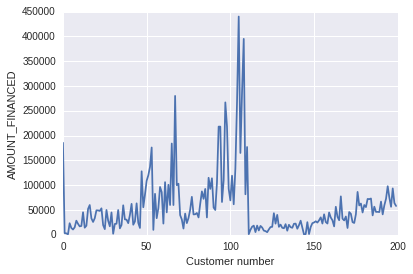

In [41]:
plt.plot(df2['AMOUNT_FINANCED'])
plt.xlabel("Customer number")
plt.ylabel("AMOUNT_FINANCED")

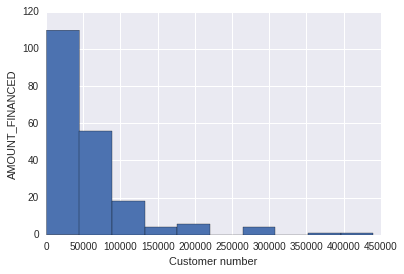

In [42]:
plt.hist(df2['AMOUNT_FINANCED'])
plt.xlabel("Customer number")
plt.ylabel("AMOUNT_FINANCED")

Almost same shapes as March's data .. 

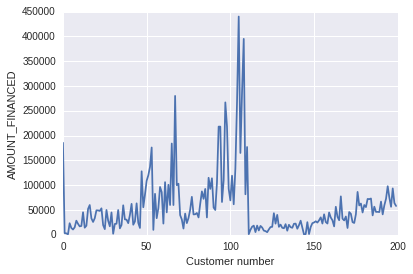

In [43]:
plt.plot(df2['AMOUNT_DISBURSED'])
plt.xlabel("Customer number")
plt.ylabel("AMOUNT_FINANCED")

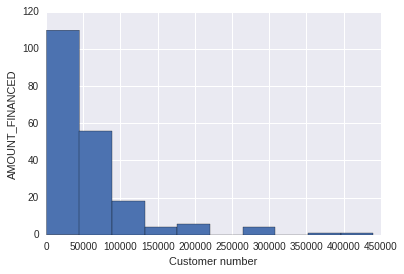

In [44]:
plt.hist(df2['AMOUNT_DISBURSED'])
plt.xlabel("Customer number")
plt.ylabel("AMOUNT_FINANCED")

It is expected to have similar shapes for the above two amounts .. as they are strongly correlated .. let's check the correlation coeffecient to assure .. 

In [45]:
## correlation .. 
df2['AMOUNT_DISBURSED'].corr(df2['AMOUNT_FINANCED'])

0.99999999999999989

## Let's plot some numerical variables:

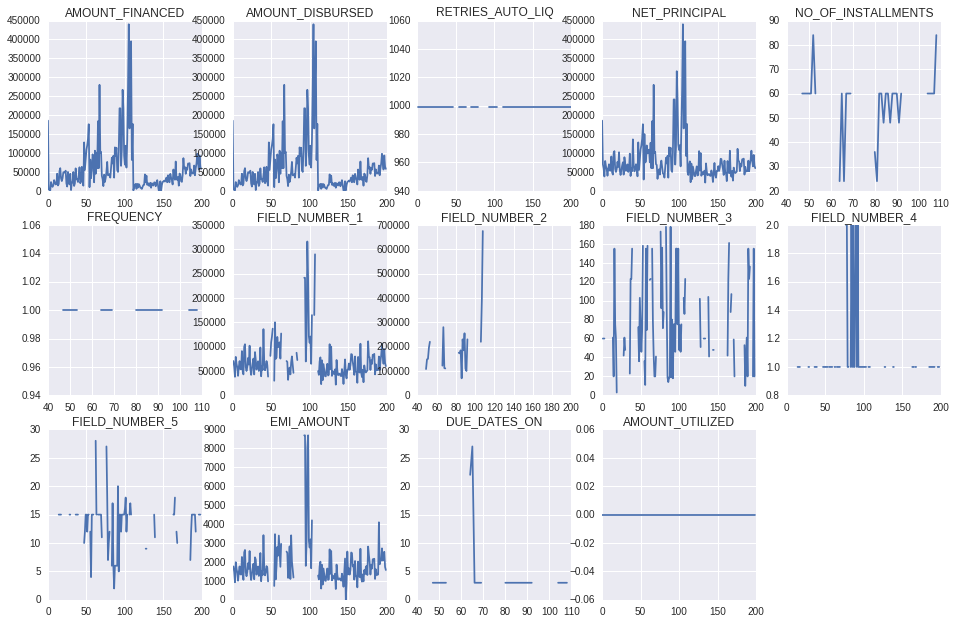

In [46]:
fig = plt.figure(figsize=(16, 80))
numeric_cols = ['AMOUNT_FINANCED', 'AMOUNT_DISBURSED', 'RETRIES_AUTO_LIQ', 'NET_PRINCIPAL', 'NO_OF_INSTALLMENTS', 
                'FREQUENCY', 'FIELD_NUMBER_1', 'FIELD_NUMBER_2', 'FIELD_NUMBER_3', 'FIELD_NUMBER_4', 'FIELD_NUMBER_5', 
                'EMI_AMOUNT', 'DUE_DATES_ON', 'AMOUNT_UTILIZED']

plot_count = 0
for numeric_col in numeric_cols:
    plot_count += 1
    plt.subplot(22, 5, plot_count)
    sns.plt.plot(numeric_col, data=df2)
    plt.title(numeric_col)

Same shapes like as of March ..  

In [47]:
df2['ACCOUNT_STATUS'] ## all possible actions ..

0      V
1      L
2      L
3      L
4      L
5      L
6      L
7      L
8      L
9      L
10     L
11     L
12     L
13     L
14     L
15     A
16     A
17     A
18     L
19     A
20     A
21     A
22     L
23     A
24     A
25     L
26     A
27     L
28     L
29     L
      ..
170    L
171    L
172    A
173    L
174    L
175    A
176    A
177    L
178    L
179    L
180    A
181    A
182    L
183    A
184    A
185    A
186    A
187    A
188    A
189    A
190    L
191    A
192    A
193    A
194    A
195    A
196    L
197    A
198    A
199    L
Name: ACCOUNT_STATUS, dtype: object

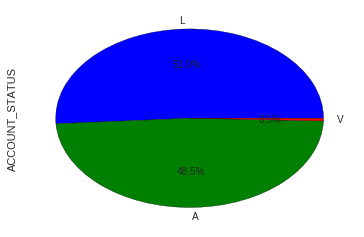

In [48]:
df2['ACCOUNT_STATUS'].value_counts().plot(x = None, y = None, kind = 'pie', autopct='%1.1f%%')

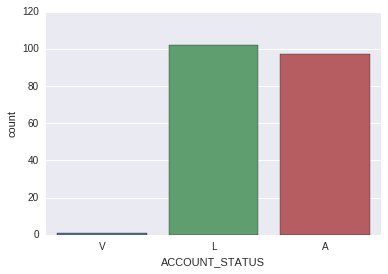

In [49]:
sns.countplot(df2['ACCOUNT_STATUS'])

In [50]:
df2['ACCOUNT_STATUS'].value_counts()

L    102
A     97
V      1
Name: ACCOUNT_STATUS, dtype: int64

slightly higher than 50% of the data belongs to 'A' (action 2) and the rest belongs to 'A' (action 3) .. only one observation has 'V' value .. 

## Filling in the missing values .. 

As shown earlier .. the data contain lots of NAs .. we already removed the columns that are all NAs .. however, we can't remove the NAs rows from the rest of the columns as their count is huge (i.e. 3000+ out of 6000+) .. hence, let's replace NAs of numerical variables by the mean value and of the categorical variables by the mode .. 

In [51]:
## although these are int .. I gonna fill them by the mode just becuase these are mainly codes .. 
cols_int = ['BRANCH_CODE',  'CUSTOMER_ID',
  'PRIMARY_APPLICANT_ID',
  'VERSION_NO',
  'LATEST_ESN',
  'PROCESS_NO',
  'FUNDED_STATUS',
  'DR_PROD_AC',
  'CR_PROD_AC',
  'DR_ACC_BRN',
  'CR_ACC_BRN',
  'LOB_ID',
  'BUCKET_NUMBER']

# df[cols_int] = df[cols_int].fillna(df[cols_int].mode())
# df[cols_int].head()

df2[cols_int] = df2[cols_int].apply(lambda x:x.fillna(x.value_counts().index[0]))
df2[cols_int].head()

,BRANCH_CODE,CUSTOMER_ID,PRIMARY_APPLICANT_ID,VERSION_NO,LATEST_ESN,PROCESS_NO,FUNDED_STATUS,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,LOB_ID,BUCKET_NUMBER
0,13,47007501,47007501,2,6,1,1000,10069780000116,26019780000043,13,13,100,0
1,13,100345296,100345296,1,31,1,1000,131100111993,131100111993,13,13,302,0
2,13,100342252,100342252,3,47,1,1000,131100111453,131100111453,13,13,302,0
3,13,100340936,100340936,1,14,1,1000,131100111123,131100111123,13,13,302,0
4,13,100389617,100389617,25,548,1,1000,132830004272,132830004272,13,13,302,0


In [52]:
## floats .. 

cols_float = ['AMOUNT_FINANCED',
  'RETRIES_AUTO_LIQ',
  'AMOUNT_DISBURSED',
  'FIELD_CHAR_3',
  'FIELD_CHAR_4',
  'FIELD_CHAR_8',
  'FIELD_CHAR_11',
  'FIELD_NUMBER_1',
  'FIELD_NUMBER_3',
  'FIELD_NUMBER_4',
  'FIELD_NUMBER_5',
  'NET_PRINCIPAL',
  'EMI_AMOUNT',
  'AMOUNT_UTILIZED']

df2[cols_float] = df2[cols_float].fillna(df2[cols_float].median())
df2[cols_float].head()

,AMOUNT_FINANCED,RETRIES_AUTO_LIQ,AMOUNT_DISBURSED,FIELD_CHAR_3,FIELD_CHAR_4,FIELD_CHAR_8,FIELD_CHAR_11,FIELD_NUMBER_1,FIELD_NUMBER_3,FIELD_NUMBER_4,FIELD_NUMBER_5,NET_PRINCIPAL,EMI_AMOUNT,AMOUNT_UTILIZED
0,185462.50,999,185462.50,2,38,21,60,62150,61,1,15,185462.5,1612.62,0
1,3446.78,999,3446.78,5,124,22,60,70400,60,1,15,70400.0,1761.37,0
2,2899.35,999,2899.35,5,124,8,60,58800,60,1,15,58800.0,1481.58,0
3,912.53,999,912.53,5,124,21,60,38000,60,1,15,38000.0,925.23,0
4,23345.17,999,23345.17,5,124,21,60,79000,61,1,15,79000.0,1986.32,0


In [53]:
cols_cat = ['ACCOUNT_NUMBER',
  'APPLICATION_NUM',
  'PRODUCT_CODE',
  'PRODUCT_CATEGORY',
  'CURRENCY',
  'PRIMARY_APPLICANT_NAME',
  'USER_DEFINED_STATUS',
  'CALC_REQD',
  'AUTO_MAN_ROLLOVER',
  'SCHEDULE_BASIS',
  'UDE_ROLLOVER_BASIS',
  'ROLLOVER_TYPE',
  'RATE_CODE_PREF',
  'PASSBOOK_FACILITY',
  'ATM_FACILITY',
  'ALLOW_BACK_PERIOD_ENTRY',
  'INT_STMT',
  'TRACK_RECEIVABLE_ALIQ',
  'TRACK_RECEIVABLE_MLIQ',
  'LIQUIDATION_MODE',
  'AMEND_PAST_PAID_SCHEDULE',
  'CHEQUE_BOOK_FACILITY',
  'LIQ_BACK_VALUED_SCHEDULES',
  'LIQ_COMP_DATES_FLAG',
  'ACCOUNT_STATUS',
  'AUTH_STAT',
  'STOP_ACCRUALS',
  'AMORTIZED',
 'RECALC_ACTION_CODE',
  'MAKER_ID',
  'CHECKER_ID',
  'ARVN_APPLIED',
  'ALT_ACC_NO',
  'PARTIAL_LIQUIDATION',
  'ALIQ_REVERSED_PMT',
  'FREQUENCY_UNIT',
  'FIRST_INS_DATE',
  'FIELD_CHAR_1',
  'FIELD_CHAR_2',
  'FIELD_CHAR_5',
  'FIELD_CHAR_6',
  'FIELD_CHAR_9',   
  'FIELD_CHAR_12',
  'FIELD_CHAR_10',
  'FIELD_CHAR_14',
  'FIELD_CHAR_15',
  'FIELD_CHAR_16',
  'FIELD_CHAR_17',
  'FIELD_CHAR_18',
  'FIELD_CHAR_19',
  'FIELD_CHAR_20',
  'FIELD_DATE_7',
  'ROLL_BY',
  'MATURITY_TYPE',
  'DR_PAYMENT_MODE',
  'CR_PAYMENT_MODE',
  'CUTOFF_TRANSACTION',
  'DELINQUENCY_STATUS',
  'USER_REF_NO',
  'ROLLOVER_ALLOWED',
  'COMMITMENT_TYPE',
  'LOAN_TYPE',
  'MODULE_CODE',
  'PACKING_CREDIT',
  'LEASE_PAYMENT_MODE',
 'ALLOW_BULK_PAYMNET',
 'STOP_DSBR',
 'INTERMEDIARY_INITIATED',
  'NOTARY_AUTO_CONFIRMED',
 'RECALC_ANNUITY',
  'LOAN_STMT_REQD',
  'SUBSYSTEMSTAT',
 'USE_GUARANTOR',
  'LOAN_AGAINST_SAL',
#  'FIRST_PAY_BY_DATE',
  'OPEN_LINE_LOAN',
  'REVOLVING_TYPE',
  'PROJECT_ACCOUNT',
  'HANDOVER_CONF',
  'LOAN_STLMNT_NOTICEFLG',
  'AUTO_CLOSE_COLLATERAL',
  'STATUS_CHANGE_MODE',
  'RATE_CHG_ACTION',
  'REC_STATUS']

# df[cols_cat].fillna(df[cols_cat].mode())  # ya3ni delw2ty el O NAs mish bettmeli 
df2[cols_cat] = df2[cols_cat].apply(lambda x:x.fillna(x.value_counts().index[0]))
df2[cols_cat].head()

,ACCOUNT_NUMBER,APPLICATION_NUM,PRODUCT_CODE,PRODUCT_CATEGORY,CURRENCY,PRIMARY_APPLICANT_NAME,USER_DEFINED_STATUS,CALC_REQD,AUTO_MAN_ROLLOVER,SCHEDULE_BASIS,...,LOAN_AGAINST_SAL,OPEN_LINE_LOAN,REVOLVING_TYPE,PROJECT_ACCOUNT,HANDOVER_CONF,LOAN_STLMNT_NOTICEFLG,AUTO_CLOSE_COLLATERAL,STATUS_CHANGE_MODE,RATE_CHG_ACTION,REC_STATUS
0,008FIDU152580003,H0013709131032,TPFI,CORPORATE,EUR,ORKILA EGYPT CHEMICALS,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
1,0130701153020001,H0013701101033,0701,RETAIL_AUTO_LOANS,EGP,BASEM220979,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
2,0130701153020002,H0013701101032,0701,RETAIL_AUTO_LOANS,EGP,NABEIH180579,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
3,0130701153020003,H0013701101031,0701,RETAIL_AUTO_LOANS,EGP,AMER160263,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
4,0130701153020004,H0013701111018,0701,RETAIL_AUTO_LOANS,EGP,HOWAIDA170670,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S


In [54]:
df2['ACCOUNT_STATUS'].value_counts()

L    102
A     97
V      1
Name: ACCOUNT_STATUS, dtype: int64

In [55]:
df2.isnull().any()

ACCOUNT_NUMBER              False
BRANCH_CODE                 False
APPLICATION_NUM             False
CUSTOMER_ID                 False
PRODUCT_CODE                False
PRODUCT_CATEGORY            False
BOOK_DATE                   False
VALUE_DATE                  False
MATURITY_DATE               False
AMOUNT_FINANCED             False
CURRENCY                    False
ORIGINAL_ST_DATE            False
PRIMARY_APPLICANT_ID        False
PRIMARY_APPLICANT_NAME      False
USER_DEFINED_STATUS         False
CALC_REQD                   False
AUTO_MAN_ROLLOVER           False
SCHEDULE_BASIS              False
UDE_ROLLOVER_BASIS          False
ROLLOVER_TYPE               False
RATE_CODE_PREF              False
PASSBOOK_FACILITY           False
ATM_FACILITY                False
ALLOW_BACK_PERIOD_ENTRY     False
INT_STMT                    False
TRACK_RECEIVABLE_ALIQ       False
TRACK_RECEIVABLE_MLIQ       False
LIQUIDATION_MODE            False
AMEND_PAST_PAID_SCHEDULE    False
CHEQUE_BOOK_FA

## Data Transformation:

As the data contains many categorical variables .. these variables will generate error while being converted to tensors (in LSTM algorithm) .. due to the disability of converting them to float32 ! .. 

I have to convert those categorical variables into numerical ones .. i.e. LOAN_STLMNT_NOTICEFLG ==> N: 0 and Y: 1

Let's start with the columns represent IDs .. i.e ACCOUNT_NUMBER or APPLICATION_NUM .. 

In [56]:
## APPLICATION_NUM 
df2[cols_cat[1]] = pd.Categorical((pd.factorize(df2[cols_cat[1]])[0] + 1).astype(str))
df2[cols_cat[1]].head()

0    1
1    2
2    3
3    4
4    5
Name: APPLICATION_NUM, dtype: category
Categories (167, object): [1, 10, 100, 101, ..., 96, 97, 98, 99]

In [57]:
for i in xrange(len(cols_cat)):
    df2[cols_cat[i]] = pd.Categorical((pd.factorize(df2[cols_cat[i]])[0] + 1).astype(str))
    
df2[cols_cat].head()

,ACCOUNT_NUMBER,APPLICATION_NUM,PRODUCT_CODE,PRODUCT_CATEGORY,CURRENCY,PRIMARY_APPLICANT_NAME,USER_DEFINED_STATUS,CALC_REQD,AUTO_MAN_ROLLOVER,SCHEDULE_BASIS,...,LOAN_AGAINST_SAL,OPEN_LINE_LOAN,REVOLVING_TYPE,PROJECT_ACCOUNT,HANDOVER_CONF,LOAN_STLMNT_NOTICEFLG,AUTO_CLOSE_COLLATERAL,STATUS_CHANGE_MODE,RATE_CHG_ACTION,REC_STATUS
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,3,3,2,2,2,3,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,4,4,2,2,2,4,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,5,5,2,2,2,5,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [58]:
df2['ACCOUNT_STATUS'].value_counts()

2    102
3     97
1      1
dtype: int64

In [59]:
for i in xrange(len(cols_date)):
    df2[cols_date[i]] = pd.Categorical((pd.factorize(df2[cols_date[i]])[0] + 1).astype(str))
    
df2[cols_date].head()

,ORIGINAL_ST_DATE,FIELD_DATE_1,FIELD_DATE_2,FIELD_DATE_3,FIELD_DATE_7,FIELD_DATE_8,FIELD_DATE_9,FIELD_DATE_10,MIGRATION_DATE,AS_OF_DATE,EXTRACTION_DATE,CHECKER_DT_STAMP,MAKER_DT_STAMP,ORIGINAL_ST_DATE,BOOK_DATE,VALUE_DATE,MATURITY_DATE
0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1
1,2,1,1,1,2,1,1,1,1,1,2,2,2,2,2,2,2
2,3,2,2,2,1,1,2,2,1,1,3,3,2,3,2,2,2
3,4,3,3,3,1,2,3,3,1,1,4,4,2,4,2,2,3
4,5,4,4,4,3,3,4,4,1,1,4,5,3,5,2,3,4


In [60]:
for i in xrange(len(cols_int)):
    df2[cols_int[i]] = pd.Categorical((pd.factorize(df2[cols_int[i]])[0] + 1).astype(str))
    
df2[cols_int].head()

,BRANCH_CODE,CUSTOMER_ID,PRIMARY_APPLICANT_ID,VERSION_NO,LATEST_ESN,PROCESS_NO,FUNDED_STATUS,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,LOB_ID,BUCKET_NUMBER
0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,2,2,2,2,1,1,2,2,1,1,2,1
2,1,3,3,3,3,1,1,3,3,1,1,2,1
3,1,4,4,2,4,1,1,4,4,1,1,2,1
4,1,5,5,4,5,1,1,5,5,1,1,2,1


In [61]:
# np.shape(np.shape(names))

df2 = pd.DataFrame(np.column_stack((df2[cols_int], df2[cols_float], df2[cols_cat], df2[cols_date])))
np.shape(df2)

(200, 127)

In [62]:
# df2 = df2.append(names, ignore_index=True)
# df2 = pd.concat([names, df2])
# df2.columns = df2.iloc[200, :] 
# df2.drop(df2.tail()[200:]) 
df2.columns = names.iloc[0, :]
df2.head()

,BRANCH_CODE,CUSTOMER_ID,PRIMARY_APPLICANT_ID,VERSION_NO,LATEST_ESN,PROCESS_NO,FUNDED_STATUS,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,...,FIELD_DATE_10,MIGRATION_DATE,AS_OF_DATE,EXTRACTION_DATE,CHECKER_DT_STAMP,MAKER_DT_STAMP,ORIGINAL_ST_DATE,BOOK_DATE,VALUE_DATE,MATURITY_DATE
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1
1,1,2,2,2,2,1,1,2,2,1,...,1,1,1,2,2,2,2,2,2,2
2,1,3,3,3,3,1,1,3,3,1,...,2,1,1,3,3,2,3,2,2,2
3,1,4,4,2,4,1,1,4,4,1,...,3,1,1,4,4,2,4,2,2,3
4,1,5,5,4,5,1,1,5,5,1,...,4,1,1,4,5,3,5,2,3,4


In [63]:
df2['ACCOUNT_STATUS'].value_counts()

2    102
3     97
1      1
Name: ACCOUNT_STATUS, dtype: int64

## LSTM .. 

- RNN - LSTM is used maily to learn the next states from the observations

- Long Short Term Memory networks “LSTMs” is implemented 


## Why LSTM-RNN ?!
1. - As customer histories are sequences of events .. 
        
        read more about LSTM in predicting customer behavior ==> 
        https://jobs.zalando.com/tech/blog/deep-learning-for-understanding-consumer-histories/?gh_src=4n3gxh1
        

2. Traditional neural network ignores the previous experience every time directly after generating the output and starts the learning process again from scratch .. RNN doesn't (is able to connect previous information to the present task) !  

3. One big problem with traditional RNNs is the vanishing (or exploding) gradient problem where, depending on the activation functions used, information rapidly gets lost over time.

4. LSTM-RNN tries to combat the vanishing / exploding gradient problem by introducing gates and an explicitly defined memory cell. These are inspired mostly by circuitry, not so much biology.

5. Becuase it is used by the comparable paper (LSTM-RNN)

6. SLTM can model long-term dependency in a customer’s interaction history.


- Tutorial for LSTM RNN ==> http://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Implementation layout: 
- We have three main types of gates each of which consists of three types of nodes 
    1. Input Gate:
          - Input node
          - Previous output
          - Bias
    2. Forget Gate:
          - Input node
          - Previous output
          - Bias
    3. Output Gate: 
          - Input node
          - Previous output
          - Bias
          
    4. Finally, we have one extra cell called (Memory cell) consists of three nodes as well 
          - Input node
          - State
          - Bias
          

- We also have (saved_output, saved_state, w, b)

In [64]:
# ## correlation .. 
# df['NET_PRINCIPAL'].corr(df['AMOUNT_FINANCED']), df['EMI_AMOUNT'].corr(df['AMOUNT_FINANCED'])

## Comment:

As stated earlier the reward of the customer is his balance in the bank .. 

As we have a lot of columns represent this balance i.e. AMOUNT_FINANCED, AMOUNT_DISBURSED, EMI_AMOUNT and NET_PRINCIPAL .. and many more .. however, only those four are valid (Not NAs and don't contain many missing values) .. 

However as there is a strong correlation between AMOUNT_FINANCED, AMOUNT_DISBURSED .. only one of them might be used .. 

Hence, the reward is represented by [AMOUNT_FINANCED, EMI_AMOUNT, NET_PRINCIPAL] ..

The current state .. is the whole record of the customer (except the above three columns) .. 

__NOTE__:

- I think it makes more sense to represent the state of the customer only by the fields representing his (Recency, Frequancy, Monetary) status .. however, just becuase they are not directly extracted and just for simplicity .. let's make his state is his whole record (if the column is only NAs .. it is excluded) .. 

- The next state is the whole record of the customer as well but for April data instead of March .. (as we don't have march's data .. let's assume that next state is also March's data .. )

- There is a column named 'STATUS_CHANGE_MODE' with only value of 'A' .. this means (Automatic) .. I will not consider this as an action .. but 'ACCOUNT_STATUS' .. that contains 'A', 'I' and other values represent the status of the account (active, inactive ...) .. As it contains 5 unique values .. I have 5 different actions for the customers .. 

In [65]:
current_states = df[df.columns.difference(['AMOUNT_FINANCED', 'EMI_AMOUNT', 'ACCOUNT_STATUS', 'ACCOUNT_NUMBER', 'FIELD_CHAR_13'])]
# ACCOUNT_NUMBER is removed cuase it cuased problem while reading it in LSTM .. 

curr_state_current_action = pd.DataFrame(np.column_stack((current_states, df['ACCOUNT_STATUS'])))

## Rewards
## let assume the rewards are only AMOUNT_FINANCED not  rewards = ['AMOUNT_FINANCED', 'EMI_AMOUNT']
rewards = ['AMOUNT_FINANCED']
for i in xrange(len(rewards)):
    df[rewards[i]] = pd.Categorical((pd.factorize(df[rewards[i]])[0] + 1).astype(str))
    
## next states 
next_states = df2[df2.columns.difference(['AMOUNT_FINANCED', 'EMI_AMOUNT', 'ACCOUNT_STATUS', 'ACCOUNT_NUMBER', 'FIELD_CHAR_13'])]


for i in xrange(len(rewards)):
    df2[rewards[i]] = pd.Categorical((pd.factorize(df2[rewards[i]])[0] + 1).astype(str))
    
    
## next actions 
next_actions = np.zeros([len(next_states), max(df2['ACCOUNT_STATUS'].unique().astype(int)) + 1])

next_actions[np.arange(next_actions.shape[0])[:], df2['ACCOUNT_STATUS'].astype(int)] = 1 ## extra column 
next_actions = np.delete(next_actions, 0, 1)  # to drop the 1st column that is all zeros ..

## next_state_next_action 
next_state_next_action1 = pd.DataFrame(np.column_stack((next_states, next_actions[:, 0])))
next_state_next_action2 = pd.DataFrame(np.column_stack((next_states, next_actions[:, 1])))
next_state_next_action3 = pd.DataFrame(np.column_stack((next_states, next_actions[:, 2])))
next_state_next_action3.head()

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,1,1,1,1,1,1,185462,0,1,1,...,1,1,1,1,1,1,1,1,1,0
1,2,1,1,2,1,1,3446.78,0,2,1,...,1,1,1,1,1,2,1,2,2,0
2,2,1,1,3,1,1,2899.35,0,3,1,...,1,1,1,1,1,3,1,2,3,0
3,2,1,1,4,1,1,912.53,0,4,1,...,1,1,1,1,1,4,1,2,2,0
4,2,1,1,5,1,1,23345.2,0,5,1,...,1,1,1,1,1,5,1,3,4,0


In [66]:
df2['ACCOUNT_STATUS'].value_counts()

2    102
3     97
1      1
Name: ACCOUNT_STATUS, dtype: int64

In [67]:
np.corrcoef(df2['ACCOUNT_STATUS'].values.astype('float') , df2['AMOUNT_FINANCED'].values.astype('float'))

array([[ 1.       ,  0.1288854],
       [ 0.1288854,  1.       ]])

there is a weak correlation between actions and rewards .. 

In [68]:
current_states = current_states.values  # convert pandas to numpy array 
curr_state_current_action = curr_state_current_action.values
next_states = next_states.values
next_state_next_action1 = next_state_next_action1.values
next_state_next_action2 = next_state_next_action2.values
next_state_next_action3 = next_state_next_action3.values

Check Nan ! .. 

In [69]:
for i in current_states:
    if i.any() == 'nan':
        print "yes"

non of the converted dataframes contain nan .. 

In [70]:
np.shape(next_states), np.shape(current_states)

((200, 123), (200, 123))

## LSTM (Model Training):

Customers data in March is considered as training set .. while their data in April is an input for validation phase .. 

## Variables initialization:

In [71]:
gamma = 0.8
Num_itrs = 10

num_epoch = 10 #epochs are cycles of Feedforward and Backprob
batch_size = 10
n_nodes_hl1 = np.shape(curr_state_current_action)[0]
n_nodes_hl2 = np.shape(curr_state_current_action)[0]
NUM_STATES = np.shape(curr_state_current_action)[1]
NUM_DIM =  np.shape(current_states)[1]
num_nodes = np.shape(curr_state_current_action)[0]
num_unrollings=5

Q_optimal = [] #np.zeros([np.shape(curr_state_current_action)[0],2])
Q_predicted = np.zeros([np.shape(curr_state_current_action)[0], len(df['ACCOUNT_STATUS'].unique())]) #np.zeros([np.shape(curr_state_current_action)[0],2])

In [72]:
df['ACCOUNT_STATUS'].unique(), df2['ACCOUNT_STATUS'].unique()

(array(['1', '2', '3'], dtype=object), array(['1', '2', '3'], dtype=object))

All possible actions are only two .. not three like March's data .. !

## Create Placeholders:

In [73]:
x = tf.placeholder(tf.float32, shape=[num_nodes, NUM_DIM + 1]) # 1 added to capture the actions 
y =  tf.placeholder(tf.float32, shape=[num_nodes, NUM_DIM])
x

<tf.Tensor 'Placeholder:0' shape=(200, 124) dtype=float32>

## Sequence to sequence RNN:

https://indico.io/blog/sequence-modeling-neuralnets-part1/ 

- Basic RNNs take each element of a sequence, multiply the element by a matrix, and then sum the result with the previous output from the network.

- To use an RNN for a language model, we take the input sequence from t=1 to t=sequence_length – 1 and try to predict the same sequence from t=2 to t=sequence_length. Since the RNN’s output is based on all previous inputs of the sequence, its output can be be expressed as Yt = g ( f (Yt-1 , Yt-2 , …Yt1 )). The function f gives the next state of the RNN, while the function g maps the state of the RNN to a value in our target vocabulary. Put simply, f gives a hidden state of the network, while g gives the output of the network – much like a softmax layer in a simple neural network.

- Sequence to sequence models build on top of language models by adding an encoder step and a decoder step. In the encoder step, a model converts an input sequence (such as an English sentence) into a fixed representation. In the decoder step, a language model is trained on both the output sequence (such as the translated sentence) as well as the fixed representation from the encoder. Since the decoder model sees an encoded representation of the input sequence as well as the translation sequence, it can make more intelligent predictions about future words based on the current word.

==> Thus, 
* Inputs: read current states
* Outputs: read next states .. w el estimated output = [nodes, num_states]
* hidden: recurrent 3adi !

## Init weights:

- Truncated_normal ==> Outputs random values from a truncated normal distribution. The generated values follow a normal distribution with specified mean and standard deviation, except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.

- The cost results were the same values however, they were changed once the range of value in trucnated normal function changed from (-0.1 to 0.1) to (0 to 1)

In [74]:
# Input gate: input, previous output, and bias.
ix = tf.Variable(tf.truncated_normal([NUM_DIM, NUM_DIM], 0, 1, dtype = tf.float32))# init_weights_RNN([n_nodes_hl1, NUM_ACTIONS])
im = tf.Variable(tf.truncated_normal([NUM_DIM, NUM_DIM], 0, 1, dtype = tf.float32))
ib = tf.Variable(tf.zeros([1, NUM_DIM], dtype = tf.float32))

# Forget gate: input, previous output, and bias.
fx = tf.Variable(tf.truncated_normal([NUM_DIM, NUM_DIM], 0, 1, dtype = tf.float32))
fm = tf.Variable(tf.truncated_normal([NUM_DIM, NUM_DIM], 0, 1, dtype = tf.float32))
fb = tf.Variable(tf.zeros([1, NUM_DIM], dtype = tf.float32))

# Memory cell: input, state and bias.                             
cx = tf.Variable(tf.truncated_normal([NUM_DIM, NUM_DIM], 0, 1, dtype = tf.float32))
cm = tf.Variable(tf.truncated_normal([NUM_DIM, NUM_DIM], 0, 1, dtype = tf.float32))
cb = tf.Variable(tf.zeros([1, NUM_DIM], dtype = tf.float32))

# Output gate: input, previous output, and bias.
ox = tf.Variable(tf.truncated_normal([NUM_DIM, NUM_DIM], 0, 1, dtype = tf.float32))
om = tf.Variable(tf.truncated_normal([NUM_DIM, NUM_DIM], 0, 1, dtype = tf.float32))
ob = tf.Variable(tf.zeros([1, NUM_DIM], dtype = tf.float32))

# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([num_nodes, np.shape(next_states)[1]], dtype = tf.float32), trainable=False) #reversed

saved_state = tf.Variable(tf.zeros([num_nodes, np.shape(next_states)[1]], dtype = tf.float32), trainable=False) #reversed

# Classifier weights and biases.
w = tf.Variable(tf.truncated_normal([NUM_DIM, NUM_DIM], 0, 1, dtype = tf.float32))
b = tf.Variable(tf.zeros([NUM_DIM], dtype = tf.float32))

## Building the model:

In [75]:
 # Definition of the cell computation.
# this method takes single cell and returns single number 
def lstm_cell(i, o, state):
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb     
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

In [76]:
def lstm_model(current_states, saved_output, saved_state):
    # Unrolled LSTM loop.    
    outputs = list()
    output = saved_output
    state = saved_state
    
#     # astype('U') .. to convert numpy array to string ..
    for i in xrange(np.shape(current_states)[0]):## el loop faydetha to copy the next line that is just for single unit 
        output_, state = lstm_cell(tf.string_to_number(current_states[i, None].astype('U')), tf.cast(output, tf.float32), tf.cast(state, tf.float32)) 
    ## in case the last values are saved !
    with tf.control_dependencies([saved_output.assign(output), saved_state.assign(state)]):
        model_output = tf.matmul(output_, w) + b # outputs single value
        
    return model_output  ## the output for the whole model

## Model training evaluation:
elli ana fahmah now, enn el RNN input is the current observation and the output is the next observations .. as if Inputs are sequance of values and outputs is also deq of values

In [77]:
def train_lstm_model():
    loss_RNN = []
    
    lstm_model(current_states, saved_output, saved_state)
    model_output = lstm_model(current_states, saved_output, saved_state) #output here is a vector
    cost = tf.reduce_mean(tf.square(y - model_output))
    train_op = tf.train.GradientDescentOptimizer(0.01).minimize(cost) 
    
    sess = tf.Session()
    init = tf.global_variables_initializer()  ## updated version from initialize_all_variables :) 
    sess.run(init)
    
    predicted_states = sess.run(model_output, feed_dict={x:curr_state_current_action, y: next_states})

    ## Cost calculation
    for step in xrange(1000):
        l,_ = sess.run([cost, train_op], feed_dict={x: curr_state_current_action, y: next_states})
        
        if step % 100 == 0:
            loss_RNN.append(l)
    

    Y_pred = tf.zeros([np.shape(next_states)[0],np.shape(next_states)[1]])

#     ## predict 
    test_pred2 = sess.run(Y_pred, feed_dict={x: curr_state_current_action})

    # rms to test ..
    cost_test = tf.reduce_mean(tf.square(next_states.astype(np.float32) - test_pred2))
    
    rmse_val = sess.run(cost_test, feed_dict={x: curr_state_current_action, y: test_pred2})
    
    sess.close()
    
    return loss_RNN,  predicted_states #saved_state, saved_output, cost_values

In [78]:
loss_RNN,  predicted_states = train_lstm_model()

In [79]:
 predicted_states

array([[-5.86745167, -4.77372551,  3.93630362, ..., -1.90556741,
         5.48724461,  3.38667107],
       [-5.86745167, -4.77372551,  3.93630362, ..., -1.90556741,
         5.48724461,  3.38667107],
       [-5.86745167, -4.77372551,  3.93630362, ..., -1.90556741,
         5.48724461,  3.38667107],
       ..., 
       [-5.86745167, -4.77372551,  3.93630362, ..., -1.90556741,
         5.48724461,  3.38667107],
       [-5.86745167, -4.77372551,  3.93630362, ..., -1.90556741,
         5.48724461,  3.38667107],
       [-5.86745167, -4.77372551,  3.93630362, ..., -1.90556741,
         5.48724461,  3.38667107]], dtype=float32)

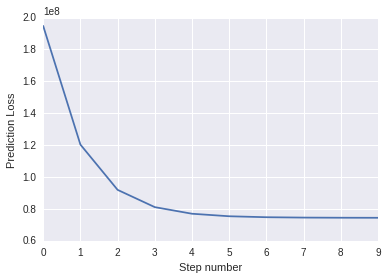

In [80]:
plt.plot(loss_RNN)
plt.xlabel('Step number')
plt.ylabel('Prediction Loss')

## Learning the rewards:
Now, the LSTM_RNN output (from validation phase) is considered as input for DQN model, to be able to select the action that has the maximum longtime reward for the customer (highest CLV) .. 

https://arxiv.org/pdf/1602.01580.pdf

## Multilayer Deep Neural Network (DQN):

https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5_Deep_Q_Network/RL_brain.py

## Data Normalization:

As the data points are already represented by categorical classes .. there might be no need to scale them again to minimize the gap between their values .. 

## Model Training:

In [81]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=1))

In [82]:
 # Definition of the cell computation.
# this method takes single cell and returns single number 
def lstm_cell(i, o, state):
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

In [83]:
def DQN_model(X, w_h_1, w_h_2, w_o, bias_I_1, bias_I_2, bias_h):

    layer_1 = tf.matmul(X, w_h_1) + bias_I_1
    layer_1 = tf.nn.relu(layer_1)  ## el performance of softmax outperforms relu!!
    
    layer_2 = tf.matmul(layer_1, w_h_2) + bias_I_2
    layer_2 = tf.nn.sigmoid(layer_2) 

    py_x = tf.matmul(layer_2, w_o) + bias_h
    
    return py_x  #predicted output
    # note that we dont take the softmax at the end because our cost fn does that for us

In [84]:
def DQN_training(X, output):
 
    w_h_1 = init_weights([np.shape(X)[1], n_nodes_hl1]) # create symbolic variables\n",
    w_h_2 = init_weights([n_nodes_hl1, n_nodes_hl2]) # create symbolic variables\n",
    w_o = init_weights([n_nodes_hl2, 1])
    
    bias_I_1=init_weights([n_nodes_hl1])
    bias_I_2=init_weights([n_nodes_hl2])
    bias_h=init_weights([1])
    
    py_x = DQN_model(tf.cast(X, tf.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)  #model training  
        
    cost = tf.reduce_mean(tf.square(py_x - output)) # compute costs",  # excpect float32

    train_op = tf.train.GradientDescentOptimizer(0.01).minimize(cost) # construct an optimizer\n",
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    sess.close()    
    return w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h

In [85]:
# ## Prediction phase: 
def DQN_predict(next_state_next_action1, next_state_next_action2, next_state_next_action3, output):

    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(next_state_next_action1, output)

    predict_op_1 = DQN_model(next_state_next_action1.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
      
        
#     print next_state_next_action2     
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(next_state_next_action2, output)
    predict_op_2 = DQN_model(next_state_next_action2.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2, bias_h)   #optimal prediction
    
    
    #     print next_state_next_action3   
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(next_state_next_action3, output)
    predict_op_3 = DQN_model(next_state_next_action3.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2, bias_h)   #optimal prediction
    
    
    
    sess2 = tf.Session()
    init2 = tf.global_variables_initializer()
    sess2.run(init2)

    l1=sess2.run(predict_op_1)
    l2=sess2.run(predict_op_2)
    l3=sess2.run(predict_op_3)
    Q_predicted = [l1, l2, l3]
    
    sess2.close()
    return np.transpose(Q_predicted)

In [86]:
for j in xrange(Num_itrs):
    
#     # Bellman equation .. that related the immdediate reward to the optimal Q
    Q_optimal = map(sum, zip(df2[rewards].values.astype(float), gamma*np.max(Q_predicted,axis = 1))) # returns max value per row !
    Q_optimal = np.array(Q_optimal, dtype=np.float32) # convert output to float32 to match py_x

    Q_predicted = DQN_predict(next_state_next_action1.astype(float), next_state_next_action2.astype(float)
                , next_state_next_action3.astype(float), Q_optimal)

print("Total output is:", Q_optimal)
print("Q fun. is: ", Q_predicted)

('Total output is:', array([[ 20.2801857 ,  16.21277809,   7.2511797 ]], dtype=float32))
('Q fun. is: ', array([[[ -7.500422  , -11.79946423,   0.53839928],
        [ -6.85576773, -15.81524658,   4.51756477],
        [ -6.85576773, -15.81524658,   4.51756477],
        [ -7.12920952, -15.81524658,   4.51756477],
        [ -8.65081406, -11.85204124,   4.1626749 ],
        [ -8.91392136, -12.13987923,   3.22615814],
        [ -8.91392136, -12.13987923,   4.22129011],
        [ -5.8049283 , -10.89056969,   2.65830469],
        [ -4.35161829, -13.86166954,  -1.40423429],
        [ -8.65081406, -11.9556675 ,   4.1626749 ],
        [ -8.65081406, -11.85204124,   4.1626749 ],
        [ -5.94504595, -12.46490669,   4.1626749 ],
        [ -4.35161829, -13.86166954,  -1.40423429],
        [ -8.65081406, -11.85204124,   4.1626749 ],
        [ -5.30255508, -12.25228882,  -2.21664095],
        [ -4.35161829, -12.99852562,  -2.05496073],
        [ -4.36630535, -14.18053722,  -2.41628551],
        [ -

## Comment:
- This was an implementation for DQN algorithm on real life data related to CAE bank ..
- Nan output is expected as the algorithm is running on only 16 records with an assumption that the next_states are equal to the current states (only becuase we have no access on the data related to another month) .. 
### - Next steps:
    1. Modify the next_states to be related to April data of the same customers .. 
    2. Run the algorithm on the whole data set to be able to obtain robust and meaningful results .. 
    
This algorithm might be upgraded to double deep Q networks .. 

https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.1_Double_DQN/RL_brain.py

## Aside Notes: 

The 10th to last session of the consumer was intense with 194 events .. 

This means enn el learning beyb2a 3la el events related to certain customer .. 

In principle, the progress of predicted order probabilities 
could also be visualized with vector-based machine learning methods like logistic regression, 
but in a cumbersome and inefficient way: We would need to re-calculate all hand-engineered features at 
every single time-step. This would be a highly redundant process: The features at time-step t would represent the 
complete history until t and not only what happened between t-1 and t. In contrast, all calculations and probabilities 
come for free in the prediction process of an RNN, as RNNs model sequences in a natural, direct way. 
More importantly, with vector-based machine learning methods, we would still need to interpret the hand-engineered 
features at every time-step to make sense of the model. If you have hundreds or thousands of features, 
and features are correlated and have been preprocessed, this is usually a complex and confusing task.


next step to check youtube videos for implementing RNN for understanding customer behavior ..

__Other implementation ideas:__
1. Predict the reward given current states and actions .. observe the actions that lead to max rewards ..

    Predicting rewards might be done using twice: 
        1.1. Standard linear least-squares regression (LR), which predicts a reward r give the current  
             observation o, assuming no long-term dependence of rewards on the history. 

        1.2. RNN: 
          This simulator thus represents a more realistic scenario that allows hidden states and long-term effects on customers 


2. Optimize Q function using both RNN an LSTM .. to be able to capture long term depencies of the data instead of just optimizing Q function (in case of traditional DQN) .. 

3. After a model is optimized using training data, it is run on test data to select actions in every step. The test data is then partitioned into two subsets: the SAME set consists of transitions where the model’s selected action is the same as the action in the data; all other transitions are in the DEVIATED set. Clearly, the partition into SAME and DEVIATED is model dependent. Finally, a model is considered better if its average reward in the corresponding SAME set is higher.

4. I may sample from the data to select portion to work on .. i.e. 100  rows follow normal distribution .. 
then split them to training, validation and testing .. 

5. add another action selection method .. rather than selecting the actions recorded in the real data .. i.e. Uniformly random policy, Probability-matching policy ..)